In [ ]:
%config Completer.use_jedi = False
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
import copy
import glob
import random

import numpy as np
import pandas as pd
from PIL import Image

from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

In [ ]:
# Paths to training data
train_normal = glob.glob('/content/drive/MyDrive/Machine Learning/Project/chest_xray/chest_xray/train/NORMAL/*')
train_pneumonia = glob.glob('/content/drive/MyDrive/Machine Learning/Project/chest_xray/chest_xray/train/PNEUMONIA/*')


In [ ]:
# Paths to Testing Data
test_normal = glob.glob('/content/drive/MyDrive/Machine Learning/Project/chest_xray/chest_xray/test/NORMAL/*')
test_pneumonia = glob.glob('/content/drive/MyDrive/Machine Learning/Project/chest_xray/chest_xray/test/PNEUMONIA/*')

In [ ]:

# Combine training and testing paths and labels
train_paths = train_normal + train_pneumonia
test_paths = test_normal + test_pneumonia

In [ ]:
train_labels =  [0] * len(train_normal) + [1] * len(train_pneumonia)
test_labels =  [0] * len(test_normal) + [1] * len(test_pneumonia)

In [ ]:
print(len(train_paths),len(train_labels))
print(len(test_paths),len(test_labels))

5216 5216
624 624


In [ ]:
assert len(train_paths) == len(train_labels), "Lengths of train_paths and train_labels must match"


In [ ]:
# Split training paths and labels into training and validation sets
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths,
                                                                        train_labels,
                                                                        stratify=train_labels)


In [ ]:

# Define a function to show random images from the dataset
def show_random_images():
    path_random_normal = random.choice(train_normal)
    path_random_abnormal = random.choice(train_pneumonia)

    fig = plt.figure(figsize=(10, 5))

    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(Image.open(path_random_normal).convert("LA"))
    ax1.set_title("Normal X-ray")

    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(Image.open(path_random_abnormal).convert("LA"))
    ax2.set_title("Abnormal X-ray")

    plt.show()


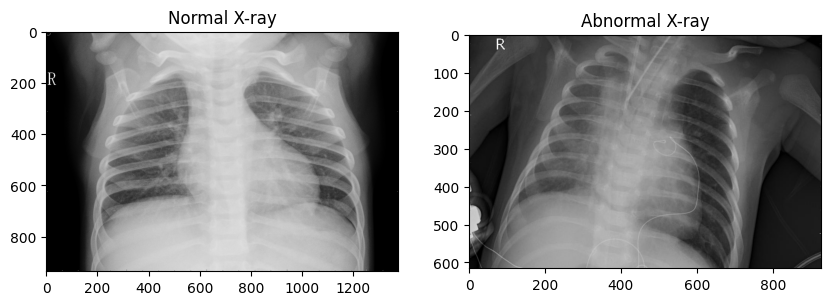

In [ ]:
show_random_images()

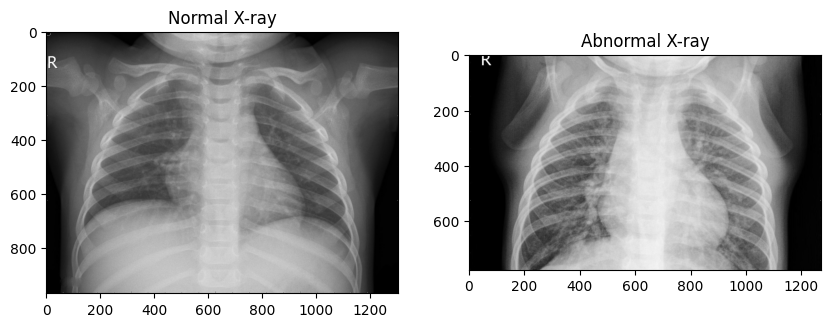

In [ ]:
show_random_images()

In [ ]:
class XrayDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[index]
        label = torch.tensor([label], dtype=torch.float32)  # Ensure the label has shape [1]

        return image, label


In [ ]:
resnet=resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.nn as nn
from torchvision.models import resnet18

class PneumoniaNet(nn.Module):
    def __init__(self, pretrained=True):
        super(PneumoniaNet, self).__init__()

        # Load the ResNet-18 backbone with or without pretraining
        self.backbone = resnet18(pretrained=pretrained)

        # Custom fully connected layer for binary classification
        self.fc = nn.Linear(in_features=512, out_features=1)

    def forward(self, x):
        # Backbone layers
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)

        # Flatten and pass through the fully connected layer
        x = x.view(x.size(0), 512)
        x = self.fc(x)

        return x


In [ ]:
from torchvision import transforms

image_size = (500, 500)

# Training dataset transformations
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Testing dataset transformations
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create instances of your custom dataset with specified transformations
train_dataset = XrayDataset(train_paths, train_labels, train_transform)
valid_dataset = XrayDataset(valid_paths, valid_labels, test_transform)


In [ ]:
pretrained = True
model = PneumoniaNet(pretrained=pretrained)
num_epochs=5
train_batch_size=16
valid_batch_size=16
lr = 0.001  # Learning rate (assuming it's defined elsewhere in your code)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size,num_workers=5, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size,num_workers=5, shuffle=False)

dataloaders = {
    "train" : train_dataloader,
    "val" : valid_dataloader
}

looping_steps = {
    "train" : len(dataloaders["train"]) //10,
    "val" : len(dataloaders["val"]) //10
}

dataset_sizes = {
    "train" : len(train_dataset),
    "val" : len(valid_dataset),
}

batch_sizes = {
    "train" : train_batch_size,
    "val" : valid_batch_size
}

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(),lr=lr)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current 

In [ ]:


print("Train Batch Size:", train_batch_size)
print("Validation Batch Size:", valid_batch_size)


Train Batch Size: 16
Validation Batch Size: 16


In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU if available
model.to(device)


PneumoniaNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
import time
import copy
import torch
from tqdm import tqdm

def train_model(model, criterion, optimizer, num_epochs, dataloaders, device="cpu", logging_steps={"train": 100, "val": 50}):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in tqdm(range(num_epochs), leave=False):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    preds = outputs.sigmoid() > 0.5
                    loss = criterion(outputs, labels.float())

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if (i % logging_steps[phase] == 0) and (i > 0):
                    avg_loss = running_loss / ((i + 1) * inputs.size(0))
                    print(f"{phase} Epoch: {epoch}, Batch: {i}, Avg Loss: {avg_loss:.4f}")

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase} Epoch: {epoch}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
model = train_model(model, criterion, optimizer, num_epochs, dataloaders={"train": train_dataloader, "val": valid_dataloader})

  0%|          | 0/5 [00:00<?, ?it/s]

train Epoch: 0, Batch: 100, Avg Loss: 0.2655
train Epoch: 0, Batch: 200, Avg Loss: 0.2062
train Epoch: 0, Loss: 0.1937, Acc: 0.9213
val Epoch: 0, Batch: 50, Avg Loss: 0.2050


 20%|██        | 1/5 [1:13:31<4:54:04, 4411.24s/it]

val Epoch: 0, Loss: 0.2052, Acc: 0.9110
train Epoch: 1, Batch: 100, Avg Loss: 0.1383
train Epoch: 1, Batch: 200, Avg Loss: 0.1463
train Epoch: 1, Loss: 0.1445, Acc: 0.9479
val Epoch: 1, Batch: 50, Avg Loss: 0.2865


 40%|████      | 2/5 [2:24:43<3:36:28, 4329.58s/it]

val Epoch: 1, Loss: 0.2551, Acc: 0.9149
train Epoch: 2, Batch: 100, Avg Loss: 0.1129


In [ ]:
test_paths = glob.glob('/content/drive/MyDrive/Machine Learning/Project/chest_xray/chest_xray/test/NORMAL/*') + glob.glob('/content/drive/MyDrive/Machine Learning/Project/chest_xray/chest_xray/test/PNEUMONIA/*')
test_labels= [0]*len(glob.glob('/content/drive/MyDrive/Machine Learning/Project/chest_xray/chest_xray/test/NORMAL/*') )+[1]*len(glob.glob('/content/drive/MyDrive/Machine Learning/Project/chest_xray/chest_xray/test/PNEUMONIA/*')
)

In [ ]:
len(test_paths),len(test_labels)

In [ ]:
test_datasets = XrayDataset(test_paths,test_labels,test_transform)

In [ ]:
test_dataLoader = DataLoader(test_datasets,batch_size=32,shuffle=False,drop_last=False)

In [ ]:
y_pred = []
y_true = []
for i, (tensors, labels) in tqdm(enumerate(test_dataLoader), leave = False, total=len(test_dataLoader)):
    with torch.no_grad():
        predictions = model(tensors.cpu())
        predictions = predictions.sigmoid()
        predictions = predictions > 0.5
        y_pred.append(predictions)

        y_true.append(labels)

In [ ]:
y_pred[0]

In [ ]:
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)

In [ ]:
y_pred.shape, y_true.shape

In [ ]:
y_pred = y_pred.cpu().numpy()
y_true = y_true.numpy()

In [ ]:
y_pred = y_pred.astype(np.int64)
y_true = y_true.astype(np.int64)

In [ ]:
y_pred = y_pred.reshape(-1)
y_true = y_true.reshape(-1)

In [ ]:
y_pred.shape,y_true.shape

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_true,y_pred)